## A pipeline for processing and analyzing multiplexed images

#### Related project: A spatial single-cell type map of adult human spermatogenesis (Cecilia Bergström group)

### Import required libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
import sklearn

# stardist
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

from skimage import io, filters, measure, segmentation, color, util, exposure, morphology
from skimage.filters import threshold_otsu

from PIL import Image
from pyotritonclient import execute
from kaibu_utils import fetch_image

import warnings
warnings.filterwarnings('ignore')

%run ../src/functions.py

### Define input path, image of interest and other parameters

In [18]:
# define input path
inputpath = '/Users/data/' # update input path!

# set to 'True' if running segmentation on the BioEngine
runBioEngine = True
# set distance to be used to grow the cell after segmentation
dist = 3

# set the segmentation method
seg_method = 'stardist' # choose between 'cellpose' of 'stardist'

# set startdist parameters
nms_thresh = 0.8
prob_thresh = 0.7

# set cellpose parameters
diameter = 30
flow_threshold = 0.4
 
# pre-process OPAL channels? True or False
preprocessOPAL = False 

# apply size filter to segmented objetcts
filterByArea = True
filterSize = 100

# define levels of Ostu threshold
multi_ostu = False

# set order of the channels
cols = ['DAPI','OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780','Autofluorescence']

# save output image files
save_img = True

### Batch process input directory

In [19]:
# create dataframe to store statistic of all files and folders
distrib_posit = pd.DataFrame()
distrib_hist = pd.DataFrame(columns=['ID','1','2','3','4','5'])
distrib_hist.set_index(['ID'], inplace=True)

for file in os.listdir(inputpath): # for each folder
    
    if os.path.isdir(inputpath+file):
        print("Folder to be processed: " + file)
        
        # Create output folder
        outpath = inputpath + file + '/output_nms-' + str(nms_thresh) + '_prob-' + str(prob_thresh) + '_filterSize-' + str(filterSize)
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        
        # create a dataframe to store mean_intens and mean_intens_thres_OPAL_nonzero
        average_intens = pd.DataFrame()
        average_intens_thres = pd.DataFrame()
        
        for im in os.listdir(inputpath+file): # for each tif file in each folder            
            if not "Simple Segmentation" in im and im.endswith('.tif'):
                
                print("file: " + im)
                
                # Load image of interest and define channel(s) to be segmented
                ref_img = io.imread(os.path.join(inputpath, file, im))

                # Select channel to be segmented: DAPI + AF
                original = ref_img[0,:,:] + ref_img[7,:,:]

                # Apply pre-processing
                print('pre-processing cell image...')
                background, filtered = preprocess(original)

                # Segment
                print('segmenting...')
                if runBioEngine:
                    param = {'nms_thresh' : nms_thresh, 'prob_thresh' : prob_thresh}
                    image = filtered.astype('uint16')

                    # run inference
                    results = await execute([image, param],server_url='https://ai.imjoy.io/triton',model_name='stardist',decode_bytes=True)
                    labels = results['mask']
                else: 
                    model = StarDist2D.from_pretrained('2D_versatile_fluo') # load pretrained model
                    labels, _ = model.predict_instances(normalize(filtered),nms_thresh=nms_thresh, prob_thresh=prob_thresh) # get predictions for nuclei

                # Get binary mask
                binary_mask = labels.copy()
                binary_mask[binary_mask > 0] = 1

                # Save segmented masks
                if save_img:
                    io.imsave(outpath + '/' + im + '_cells_labels.tif',labels)
                    io.imsave(outpath + '/' + im + '_cells_binary.tif',util.img_as_ubyte(binary_mask*255))
                
                # Expand labels to incorporate cells' neighborhoods
                expanded_labels = segmentation.expand_labels(labels, distance=dist)
                if save_img:
                    io.imsave(outpath + '/' + im + '_cells_labels_expanded.tif',expanded_labels)
                
                # Get average intensity 
                print('quantifying...')
                properties = ['label', 'intensity_mean']
                mean_intens = get_avg_intensity(ref_img, expanded_labels, cols, properties)
                
                # concatenate dataframes
                # create ID based on image file name
                file_name = im.replace('_component_data.tif','')
                ID = pd.Series(file_name)
                ID = ID.repeat(mean_intens.shape[0])
                
                # concat
                mean_intens['ID'] = ID.values
                mean_intens.reset_index(['label'],inplace=True)
                mean_intens.set_index(['ID','label'],inplace=True)                
                average_intens = pd.concat([average_intens, mean_intens], axis=0)
                
                # get enlarged-labels image as a binary mask
                expanded_binary_mask = expanded_labels.copy()
                expanded_binary_mask[expanded_binary_mask > 0] = 1
                
                # OPAL quantification
                # load Ilastik mask
                ilastik_mask = im.replace('.tif','')
                ilastik_mask = ilastik_mask.replace('[','')
                ilastik_mask = ilastik_mask.replace(']','')
                ilastik_mask = inputpath + file + '/' +  ilastik_mask + '_520_Simple Segmentation.tiff'
                mean_intens_thres, thresholded, intens_masks = opal_quantification(ref_img, expanded_labels, expanded_binary_mask, ilastik_mask, cols, filterByArea, filterSize, preprocessOPAL, multi_ostu)
                
                # filter ['DAPI', 'Autofluorescence','OPAL520'] out
                mean_intens_thres = filter_columns(['DAPI', 'Autofluorescence'], mean_intens_thres)

                # concatenate dataframes
                ID = pd.Series(file_name)
                ID = ID.repeat(mean_intens_thres.shape[0])
                mean_intens_thres['ID'] = ID.values
                mean_intens_thres.reset_index(['label'],inplace=True)
                mean_intens_thres.set_index(['ID','label'],inplace=True)    
                average_intens_thres = pd.concat([average_intens_thres, mean_intens_thres], axis=0)
                
                cols_filtered = ['OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780']
                if save_img:
                    save_results_opal_quantification(cols_filtered, outpath + '/' + im, thresholded, intens_masks)
                
                # filter ['OPAL520'] out
                mean_intens_thres_OPAL = filter_columns(['OPAL520'], mean_intens_thres)
                
                # rearrange cols order
                cols_sorted = ['OPAL480', 'OPAL620', 'OPAL690', 'OPAL780', 'OPAL570']
                mean_intens_thres_OPAL = mean_intens_thres_OPAL[cols_sorted]
                
                # remove rows with all cols zero value
                mean_intens_thres_OPAL_nonzero = mean_intens_thres_OPAL.loc[~(mean_intens_thres_OPAL==0).all(axis=1)]
                
                # get stats of positive signals
                n, bins, signal_stats = get_hist_pos_signal(mean_intens_thres_OPAL, mean_intens_thres_OPAL_nonzero)
                
                # n and bins should be concatenated and saved together for all files and folders
                ind = distrib_hist.shape[0]
                idm = file_name
                new_row = pd.DataFrame([[n[0], n[1], n[2], n[3], n[4]]], columns=['1','2','3','4','5'], index=[idm])
                distrib_hist = distrib_hist.append(new_row)
                
                # signal_stats should be saved for all files and folders
                cols_stats = ['OPAL480', 'OPAL620', 'OPAL690', 'OPAL780', 'OPAL570', 'size']
                stats_df = pd.DataFrame(signal_stats, columns=cols_stats)
                ID = pd.Series(file_name)
                ID = ID.repeat(signal_stats.shape[0])
                stats_df['ID'] = ID.values
                stats_df.set_index(['ID'], inplace=True)
                distrib_posit = pd.concat([distrib_posit, stats_df], axis=0)
                
                print(' ')
        
        average_intens.to_csv(os.path.join(outpath + '/mean_intensity.csv'), sep=';')
        average_intens_thres.to_csv(os.path.join(outpath + '/mean_intensity_threshold.csv'), sep=';')
        
distrib_hist.to_csv(os.path.join(inputpath + '/histogram.csv'), sep=';')
distrib_posit.to_csv(os.path.join(inputpath + '/distribution_per_positive.csv'), sep=';')   

FileNotFoundError: [Errno 2] No such file or directory: '/Users/data/'

## Running the pipeline for reference image

### Load image of interest and define channel to be segmented

Nuclei and AF channel: loaded  (3996, 3996)
Pre-processing cell image: finished


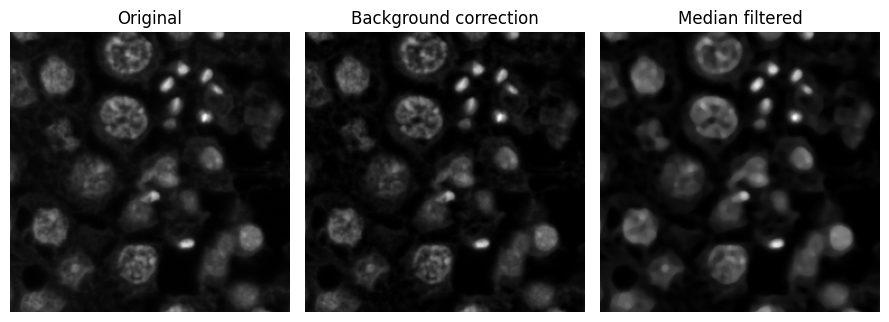

In [20]:
# Define paths
path = '/Users/giselemiranda/ToOneDrive/BIIF/projects/Feria_Cecilia/test_input/20456931_otsu/' # update input path!
ref_image = '20456931_Core[1,2,A]_[13058,43408]_component_data.tif'
ilastik_mask = '20456931_Core1,2,A_13058,43408_component_data_520_Simple Segmentation.tiff'

outpath = path + '/output_nms-' + str(nms_thresh) + '_prob-' + str(prob_thresh) + '_filterSize-' + str(filterSize)
if not os.path.exists(outpath):
    os.makedirs(outpath)

# Read reference image

ref_img = io.imread(os.path.join(path, ref_image))

# Select channel to be segmented
original = ref_img[0,:,:] + ref_img[7,:,:]
print("Nuclei and AF channel: loaded ", original.shape)

# Apply pre-processing to the AF channel
background, filtered = preprocess(original)
print("Pre-processing cell image: finished")

# Show pre-processing
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(exposure.rescale_intensity(original[1000:1250, 1000:1250]), cmap="gray")
axes[0].set_title("Original")

axes[1].imshow(exposure.rescale_intensity(background[1000:1250, 1000:1250]), cmap="gray")
axes[1].set_title("Background correction")

axes[2].imshow(exposure.rescale_intensity(filtered[1000:1250, 1000:1250]), cmap="gray")
axes[2].set_title("Median filtered")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()

### Run cell segmentation and save both label and binary masks

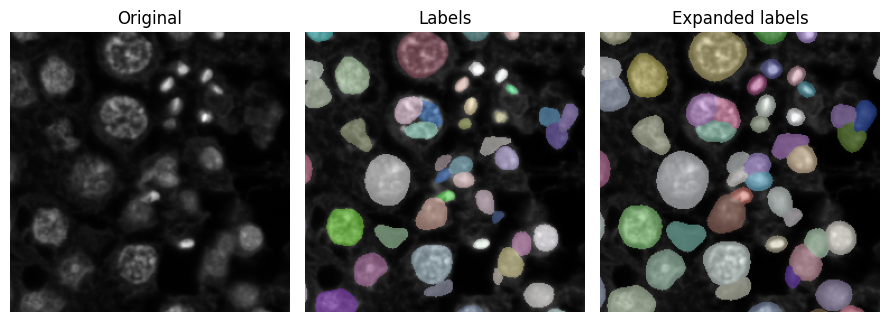

In [21]:
if runBioEngine:
    param = {'nms_thresh' : nms_thresh, 'prob_thresh' : prob_thresh}
    image = filtered.astype('uint16')

    # run inference
    results = await execute([image, param],server_url='https://ai.imjoy.io/triton',model_name='stardist',decode_bytes=True)
    labels = results['mask']
else: 
    model = StarDist2D.from_pretrained('2D_versatile_fluo') # load pretrained model
    labels, _ = model.predict_instances(normalize(filtered),nms_thresh=nms_thresh, prob_thresh=prob_thresh) # get predictions for nuclei

# Get binary mask
binary_mask = labels.copy()
binary_mask[binary_mask > 0] = 1

io.imsave(outpath + '/_cells_labels.tif',labels)
io.imsave(outpath + '/_cells_binary.tif',util.img_as_ubyte(binary_mask*255))

### Expand labels to incorporate cells' neighborhoods
expanded_labels = segmentation.expand_labels(labels, distance=dist)
io.imsave(outpath + '/_cells_labels_expanded.tif',expanded_labels)

# Show the segmentations.
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(exposure.rescale_intensity(original[1000:1250, 1000:1250]), cmap="gray")
axes[0].set_title("Original")

axes[1].imshow(render_label(labels, img=original)[1000:1250, 1000:1250])
axes[1].set_title("Labels")

axes[2].imshow(render_label(expanded_labels, img=original)[1000:1250, 1000:1250])
axes[2].set_title("Expanded labels")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()


### Retrieve quantitative measures
### 1) Get mean fluorescence intensity for each nuclei and for each channel and save results on a dataframe


In [22]:
properties = ['label', 'intensity_mean']

mean_intens = get_avg_intensity(ref_img, expanded_labels, cols, properties)

# add file id
ref_series = pd.Series(ref_image)
ref_series = ref_series.repeat(mean_intens.shape[0])
mean_intens['file'] = ref_series.values
mean_intens.reset_index(['label'],inplace=True)
mean_intens.set_index(['file','label'],inplace=True)
# save as csv
mean_intens.to_csv(os.path.join(outpath, 'mean_intensity.csv'), sep=';')

# exclude DAPI, AF and OPAL520 from dataframe
mean_intens_OPAL = mean_intens.drop(columns=['DAPI', 'Autofluorescence', 'OPAL520'], axis=1)

# rearrange cols
cols_sorted = ['OPAL480', 'OPAL620', 'OPAL690', 'OPAL780', 'OPAL570']
mean_intens_OPAL = mean_intens_OPAL[cols_sorted]
mean_intens_OPAL

OPAL480  \
file                                               label              
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       1.111724   
                                                   2      69.919998   
                                                   3      71.594398   
                                                   4       0.991627   
                                                   5      11.651151   
...                                                             ...   
                                                   5779    3.018270   
                                                   5780    0.934608   
                                                   5781    1.491884   
                                                   5782    5.543497   
                                                   5783    0.342100   

                                                            OPAL620   OPAL690  \
file                                               label                        
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       1.142393  1.022249   
                                                   2       1.300789  0.442929   
                                                   3       3.405338  0.219846   
                                                   4       1.019510  1.234947   
                                                   5      17.985025  0.283304   
...                                                             ...       ...   
                                                   5779    2.731048  0.627000   
                                                   5780    2.304307  0.119029   
                                                   5781    6.880110  0.094764   
                                                   5782    8.628377  0.627150   
                                                   5783    0.174180  0.401320   

                                                           OPAL780   OPAL570  
file                                               label                      
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      0.098827  0.025207  
                                                   2      0.037230  0.000742  
                                                   3      0.031133  0.002772  
                                                   4      0.089436  0.014621  
                                                   5      0.124341  0.031287  
...                                                            ...       ...  
                                                   5779   0.174777  0.075852  
                                                   5780   0.043045  0.000391  
                                                   5781   0.274405  0.033455  
                                                   5782   0.249950  0.395997  
                                                   5783   0.015747  0.000000  

[5783 rows x 5 columns]

#### Z-score normalization and PCA

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# z-norm
scaler = StandardScaler()
mean_intens_OPAL_znorm = scaler.fit_transform(mean_intens_OPAL)
mean_intens_OPAL_znorm

# PCA
pca = PCA(n_components=3)
fit_pca = pca.fit_transform(mean_intens_OPAL_znorm)

#### K-means clustering of the PCA data

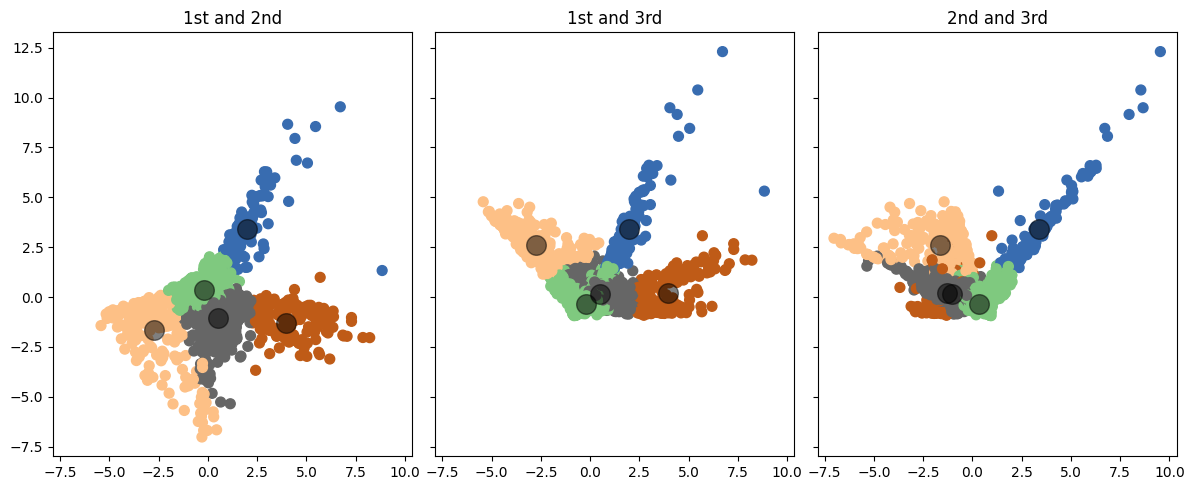

In [24]:
from sklearn.cluster import KMeans

data = fit_pca # mean_intens_znorm or fit_pca or mean_intens_OPAL

kmeans = KMeans(n_clusters = 5, random_state = 0, n_init='auto', init='k-means++')
kmeans.fit(data)
y_kmeans = kmeans.predict(data)
centers_kmeans = kmeans.cluster_centers_

plot_clusters(data,y_kmeans,centers_kmeans,True)

#### Gaussian Mixture Model of the PCA data

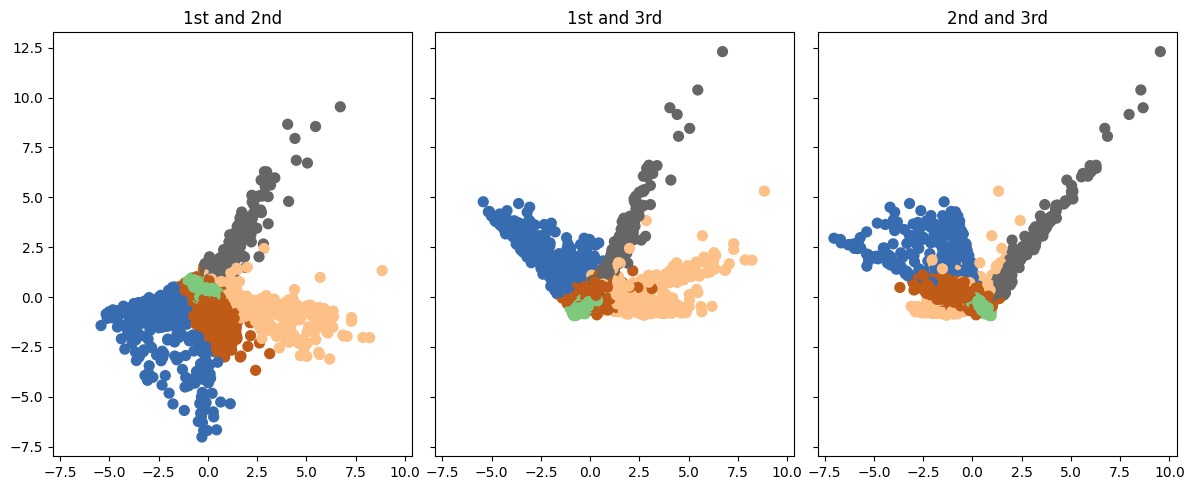

In [25]:
from sklearn.mixture import GaussianMixture

n_components = 5  # number of clusters
covariance_type = 'full'  # each component has its own general covariance matrix
gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)

# set GMM parameters
max_iter = 100  # maximum number of iterations
tol = 1e-3  # convergence tolerance
gmm.set_params(max_iter=max_iter, tol=tol)

y_gmm = gmm.fit_predict(data)

plot_clusters(data,y_gmm,'',False)

### 2) Get mean fluorescence intensity for each nuclei and for each channel, given the thresholded masks, and save results on a dataframe

In [26]:
# get enlarged-labels image as a binary mask
expanded_binary_mask = expanded_labels.copy()
expanded_binary_mask[expanded_binary_mask > 0] = 1

# OPAL quantification
ilastik_mask = path + ilastik_mask
mean_intens_thres, thresholded, intens_masks = opal_quantification(ref_img, expanded_labels, expanded_binary_mask, ilastik_mask, cols, filterByArea, filterSize, preprocessOPAL, multi_ostu)

# filter ['DAPI', 'Autofluorescence'] out
mean_intens_thres = filter_columns(['DAPI', 'Autofluorescence'], mean_intens_thres)

# add file id
mean_intens_thres['file'] = ref_series.values
mean_intens_thres.reset_index(['label'],inplace=True)
mean_intens_thres.set_index(['file','label'],inplace=True)
mean_intens_thres.to_csv(os.path.join(outpath, 'mean_intensity_threshold.csv'), sep=';')

mean_intens_thres

channel: DAPI
channel: OPAL480
channel: OPAL520
channel: OPAL570
channel: OPAL620
channel: OPAL690
channel: OPAL780
channel: Autofluorescence


OPAL480  \
file                                               label              
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.000000   
                                                   2      80.577100   
                                                   3      81.714165   
                                                   4       0.000000   
                                                   5       0.000000   
...                                                             ...   
                                                   5779    0.000000   
                                                   5780    0.000000   
                                                   5781    0.000000   
                                                   5782    0.000000   
                                                   5783    0.000000   

                                                            OPAL520  OPAL570  \
file                                               label                       
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      22.958770      0.0   
                                                   2       0.000000      0.0   
                                                   3       0.000000      0.0   
                                                   4      22.195398      0.0   
                                                   5      37.092554      0.0   
...                                                             ...      ...   
                                                   5779    3.694002      0.0   
                                                   5780    0.000000      0.0   
                                                   5781    0.000000      0.0   
                                                   5782   17.868627      0.0   
                                                   5783    9.487898      0.0   

                                                            OPAL620  OPAL690  \
file                                               label                       
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.000000      0.0   
                                                   2       0.000000      0.0   
                                                   3      12.332651      0.0   
                                                   4       0.000000      0.0   
                                                   5      24.536188      0.0   
...                                                             ...      ...   
                                                   5779    0.000000      0.0   
                                                   5780    0.000000      0.0   
                                                   5781    0.000000      0.0   
                                                   5782   14.443435      0.0   
                                                   5783    0.000000      0.0   

                                                           OPAL780  
file                                               label            
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      0.281614  
                                                   2      0.235519  
                                                   3      0.000000  
                                                   4      0.000000  
                                                   5      0.306877  
...                                                            ...  
                                                   5779   0.000000  
                                                   5780   0.000000  
                                                   5781   0.347870  
                                                   5782   0.346438  
                                                   5783   0.000000  

[5783 rows x 6 columns]

In [27]:
# save masks
cols_filtered = ['OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780']
save_results_opal_quantification(cols_filtered, outpath + '/' + ref_image , thresholded, intens_masks)

# filter ['OPAL520'] out
mean_intens_thres_OPAL = filter_columns(['OPAL520'], mean_intens_thres)

# rearrange cols order
cols_sorted = ['OPAL480', 'OPAL620', 'OPAL690', 'OPAL780', 'OPAL570']
mean_intens_thres_OPAL = mean_intens_thres_OPAL[cols_sorted]
mean_intens_thres_OPAL

OPAL480  \
file                                               label              
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.000000   
                                                   2      80.577100   
                                                   3      81.714165   
                                                   4       0.000000   
                                                   5       0.000000   
...                                                             ...   
                                                   5779    0.000000   
                                                   5780    0.000000   
                                                   5781    0.000000   
                                                   5782    0.000000   
                                                   5783    0.000000   

                                                            OPAL620  OPAL690  \
file                                               label                       
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.000000      0.0   
                                                   2       0.000000      0.0   
                                                   3      12.332651      0.0   
                                                   4       0.000000      0.0   
                                                   5      24.536188      0.0   
...                                                             ...      ...   
                                                   5779    0.000000      0.0   
                                                   5780    0.000000      0.0   
                                                   5781    0.000000      0.0   
                                                   5782   14.443435      0.0   
                                                   5783    0.000000      0.0   

                                                           OPAL780  OPAL570  
file                                               label                     
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      0.281614      0.0  
                                                   2      0.235519      0.0  
                                                   3      0.000000      0.0  
                                                   4      0.000000      0.0  
                                                   5      0.306877      0.0  
...                                                            ...      ...  
                                                   5779   0.000000      0.0  
                                                   5780   0.000000      0.0  
                                                   5781   0.347870      0.0  
                                                   5782   0.346438      0.0  
                                                   5783   0.000000      0.0  

[5783 rows x 5 columns]

In [28]:
# remove rows with all cols zero value
mean_intens_thres_OPAL_nonzero = mean_intens_thres_OPAL.loc[~(mean_intens_thres_OPAL==0).all(axis=1)]
mean_intens_thres_OPAL_nonzero

# counting of cols with values > 0 per row
OPAL_counts = mean_intens_thres_OPAL_nonzero.copy()
OPAL_counts['total_positive'] = mean_intens_thres_OPAL_nonzero[mean_intens_thres_OPAL_nonzero > 0].count(axis='columns')
OPAL_counts

OPAL480  \
file                                               label              
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.000000   
                                                   2      80.577100   
                                                   3      81.714165   
                                                   5       0.000000   
                                                   6       0.000000   
...                                                             ...   
                                                   5772    0.000000   
                                                   5776    0.000000   
                                                   5778    0.000000   
                                                   5781    0.000000   
                                                   5782    0.000000   

                                                            OPAL620  OPAL690  \
file                                               label                       
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.000000      0.0   
                                                   2       0.000000      0.0   
                                                   3      12.332651      0.0   
                                                   5      24.536188      0.0   
                                                   6       0.000000      0.0   
...                                                             ...      ...   
                                                   5772   14.525606      0.0   
                                                   5776    0.000000      0.0   
                                                   5778    0.000000      0.0   
                                                   5781    0.000000      0.0   
                                                   5782   14.443435      0.0   

                                                           OPAL780  OPAL570  \
file                                               label                      
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      0.281614      0.0   
                                                   2      0.235519      0.0   
                                                   3      0.000000      0.0   
                                                   5      0.306877      0.0   
                                                   6      0.315466      0.0   
...                                                            ...      ...   
                                                   5772   0.309266      0.0   
                                                   5776   0.271764      0.0   
                                                   5778   0.345881      0.0   
                                                   5781   0.347870      0.0   
                                                   5782   0.346438      0.0   

                                                          total_positive  
file                                               label                  
20456931_Core[1,2,A]_[13058,43408]_component_da... 1                   1  
                                                   2                   2  
                                                   3                   2  
                                                   5                   2  
                                                   6                   1  
...                                                                  ...  
                                                   5772                2  
                                                   5776                1  
                                                   5778                1  
                                                   5781                1  
                                                   5782                2  

[3820 rows x 6 columns]

#### Distribution of postive signals per col

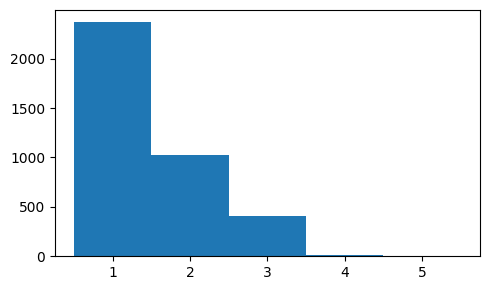

2374.0
1024.0
411.0
11.0
0.0


In [29]:
# plot histogram of total_positive
fig, ax = plt.subplots(figsize=(5, 3))
n, bins, patches = ax.hist(OPAL_counts['total_positive'], bins=[1,2,3,4,5,6], align='left')
fig.tight_layout()
plt.show()

print(n[0])
print(n[1])
print(n[2])
print(n[3])
print(n[4])

In [30]:
# transform the data to count unique patterns
mean_intens_unit = mean_intens_thres_OPAL.copy()
mean_intens_unit = mean_intens_unit.loc[~(mean_intens_unit==0).all(axis=1)]
mean_intens_unit[mean_intens_unit > 0] = 1
mean_intens_unit

OPAL480  OPAL620  \
file                                               label                     
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0      0.0   
                                                   2          1.0      0.0   
                                                   3          1.0      1.0   
                                                   5          0.0      1.0   
                                                   6          0.0      0.0   
...                                                           ...      ...   
                                                   5772       0.0      1.0   
                                                   5776       0.0      0.0   
                                                   5778       0.0      0.0   
                                                   5781       0.0      0.0   
                                                   5782       0.0      1.0   

                                                          OPAL690  OPAL780  \
file                                               label                     
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0      1.0   
                                                   2          0.0      1.0   
                                                   3          0.0      0.0   
                                                   5          0.0      1.0   
                                                   6          0.0      1.0   
...                                                           ...      ...   
                                                   5772       0.0      1.0   
                                                   5776       0.0      1.0   
                                                   5778       0.0      1.0   
                                                   5781       0.0      1.0   
                                                   5782       0.0      1.0   

                                                          OPAL570  
file                                               label           
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0  
                                                   2          0.0  
                                                   3          0.0  
                                                   5          0.0  
                                                   6          0.0  
...                                                           ...  
                                                   5772       0.0  
                                                   5776       0.0  
                                                   5778       0.0  
                                                   5781       0.0  
                                                   5782       0.0  

[3820 rows x 5 columns]

In [31]:
# show distribution of positive signals
mean_intens_unit.groupby(mean_intens_unit.columns.tolist(),as_index=False).size()

,OPAL480,OPAL620,OPAL690,OPAL780,OPAL570,size
0,0.0,0.0,0.0,0.0,1.0,53
1,0.0,0.0,0.0,1.0,0.0,1964
2,0.0,0.0,0.0,1.0,1.0,84
3,0.0,0.0,1.0,0.0,0.0,87
4,0.0,0.0,1.0,1.0,0.0,271
5,0.0,0.0,1.0,1.0,1.0,5
6,0.0,1.0,0.0,0.0,0.0,174
7,0.0,1.0,0.0,1.0,0.0,474
8,0.0,1.0,0.0,1.0,1.0,2
9,0.0,1.0,1.0,0.0,0.0,76
